# Monk Notebook

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.network import NeuralNetwork
from model.trainer import Trainer
from model.losses import Loss
from utils import DataLoader
from utils import load_monk, plot_curves
from utils.model_selection_helpers import count_parameters
from model.activations import sigmoid
from model.losses import mse
from utils.grid_search import grid_search_monk
from IPython.display import clear_output

np.random.seed(8) #reproducibility

In [2]:
# All the configurations to test for the training
# Neural Network architectures
INPUT_NEURONS = 17
OUTPUT_NEURONS = 1

HIDDEN_LAYER_SIZES = [4, 8]
HIDDEN_LAYERS_COUNTS = [1, 2]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('sigmoid', 'mse'), ('identity', 'binary cross entropy sigmoid')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

# Training parameters
ETA_CONFIGURATIONS = [0.25, 0.1]
LAMBDA_CONFIGURATIONS = [0, 1e-1, 1e-2, 1e-3]
ALPHA_CONFIGURATIONS = [0, 0.5, 0.9]
BATCH_SIZES = [32, -1]

# Cross-validation parameters
K_FOLDS= 5
EPOCHS = 500
EARLY_STOPPING_PATIENCE = 50

# All possible configurations are tuples (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        for BATCH_SIZE in BATCH_SIZES:
            config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
            CONFIGURATIONS.append(config)
LEN_CONFIGURATIONS = len(CONFIGURATIONS)

print(f"Total configurations: {LEN_CONFIGURATIONS}")

Total configurations: 1152


## Monk 1

In [3]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-1.train'
PATH_TEST = 'data/monk/monks-1.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_1 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_1.k_fold(k = K_FOLDS)

After one-hot encoding: X train full shape: (124, 17), X test shape: (432, 17), y train full shape: (124, 1), y test shape: (432, 1)


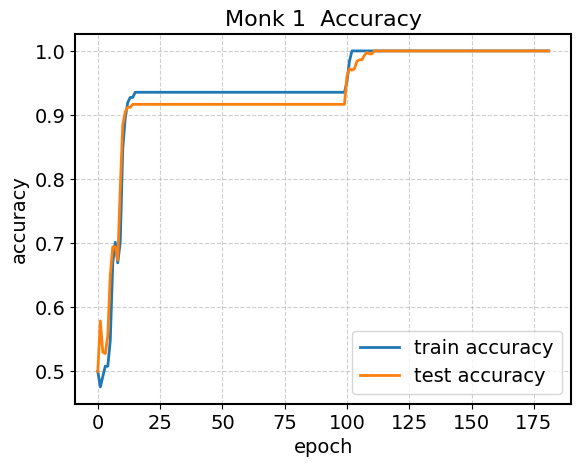

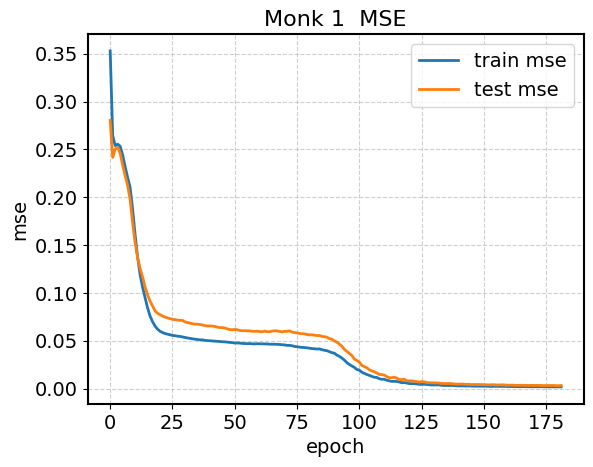

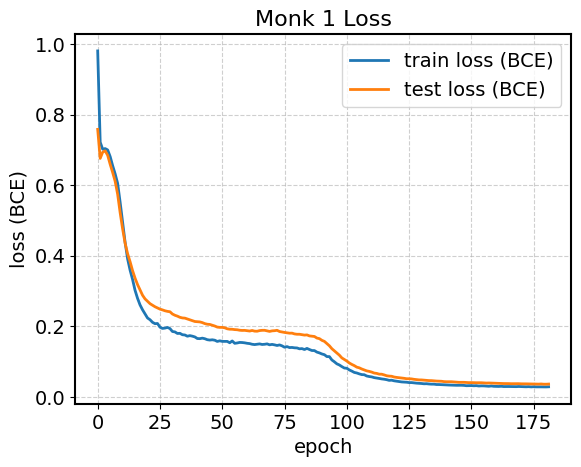

Train loss BCE: 0.028576803279136462, Test loss BCE: (np.float64(0.036312375398669675),)
Train MSE: 0.0017652637416404355
Train Accuracy: 100.0%
Test MSE: 0.00315063747232861
Validation Accuracy: 100.0%



In [4]:
### chosen configuration
'''Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.1, 0.001, 0.9, 32), Mean Accuracy: 100.0%,
            training instability coeff validation: 7.251121972242489, 
            training instability coeff train: 18.125499760799777, 
            training loss-val loss diff: 8.502494598628806, 
            Mean Epochs: 182'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.1, 0.001, 0.9, 32
EPOCHS = 182

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_monk=True, plot_title='Monk 1 ')

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 1 Loss', save_plots=True)
print(f"Train loss BCE: {train_loss_vector[-1]}, Test loss BCE: {test_loss_vector[-1],}")

out = nn.forward(X_train_full)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

print(f"Train MSE: {np.mean(mse(out, y_train_full))}")
predictions = np.round(out)
print(f"Train Accuracy: {np.mean(predictions == y_train_full) * 100}%")

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)
print(f"Test MSE: {np.mean(mse(out, y_test))}")

predictions = np.round(out)
print(f"Validation Accuracy: {np.mean(predictions == y_test) * 100}%")

print()

## Monk 2

In [5]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-2.train'
PATH_TEST = 'data/monk/monks-2.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_2 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_2.k_fold(k = K_FOLDS)

After one-hot encoding: X train full shape: (169, 17), X test shape: (432, 17), y train full shape: (169, 1), y test shape: (432, 1)


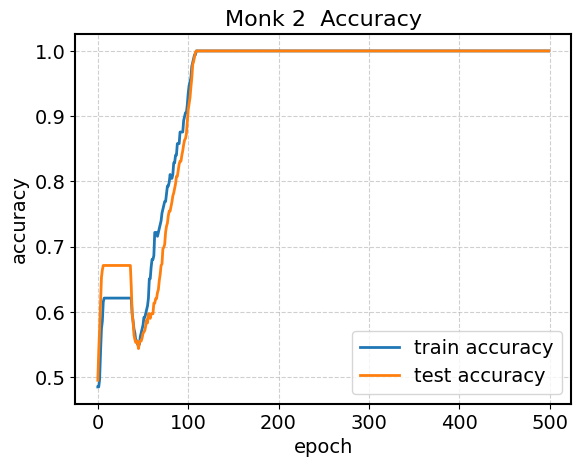

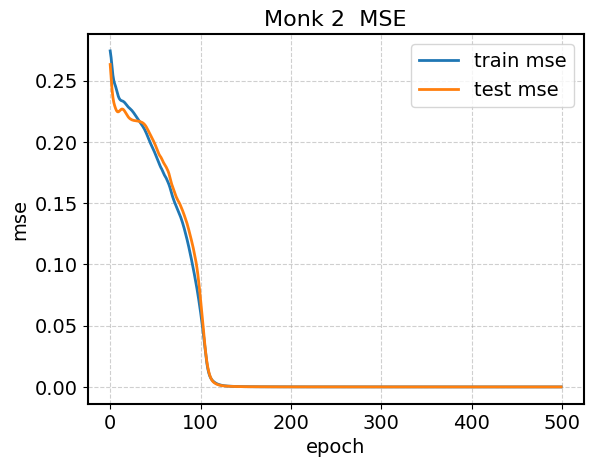

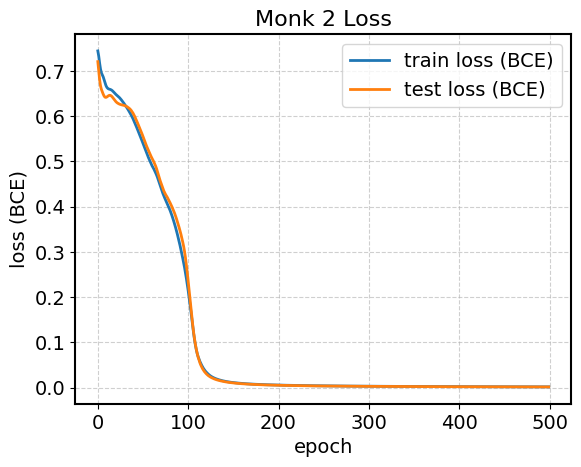

Train loss: 0.0015110593632503646, Test loss: (np.float64(0.0013918196138949358),)
Train Accuracy: 100.0%
Validation Accuracy: 100.0%


In [6]:
### chosen configuration
'''Config index: ([17, 4, 1], ['leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.25, 0, 0.9, -1), Mean Accuracy: 100.0%,
            training instability coeff validation: 0.21730799802185136, 
            training instability coeff train: 0.05647236271957169, 
            training loss-val loss diff: 5.611568195799458, 
            Mean Epochs: 500'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 4, 1], ['leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.25, 0, 0.9, -1
EPOCHS = 500

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_monk=True, plot_title='Monk 2 ')

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 2 Loss', save_plots=True)

print(f"Train loss: {train_loss_vector[-1]}, Test loss: {test_loss_vector[-1],}")

out = nn.forward(X_train_full)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Train Accuracy: {np.mean(predictions == y_train_full) * 100}%")
# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Validation Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 3

In [3]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-3.train'
PATH_TEST = 'data/monk/monks-3.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_3 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_3.k_fold(k = K_FOLDS)

After one-hot encoding: X train full shape: (122, 17), X test shape: (432, 17), y train full shape: (122, 1), y test shape: (432, 1)


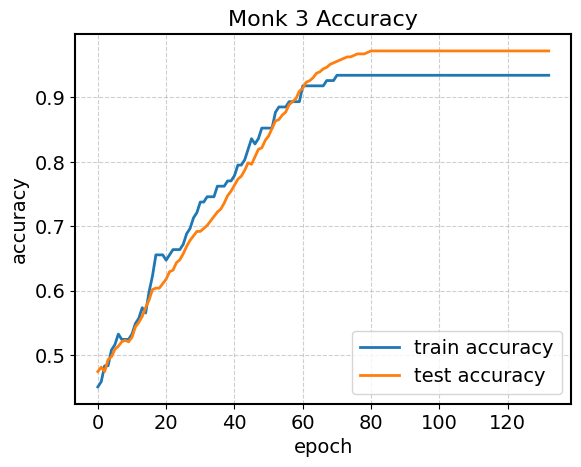

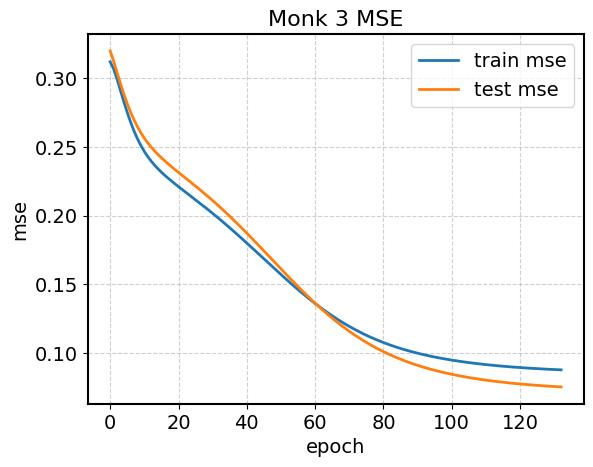

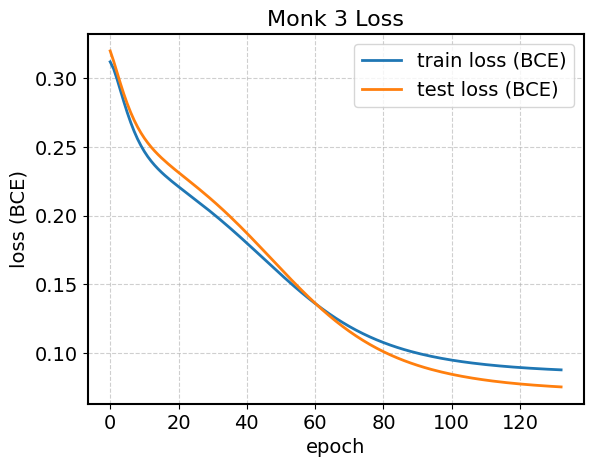

Train loss: 0.0875667222410699, Test loss: (np.float64(0.07513560019474548),)
Train Accuracy: 93.44262295081968%
Validation Accuracy: 97.22222222222221%


In [4]:
### chosen configuration
'''Config index: ([17, 4, 1], ['tanh', 'sigmoid'], 'mse', 0.25, 0.01, 0.5, -1), Mean Accuracy: 93.5%,
            training instability coeff validation: 0.0007768047741556949, 
            training instability coeff train: 0.0, 
            training loss-val loss diff: 1.9177302710431792, 
            Mean Epochs: 133
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 4, 1], ['tanh', 'sigmoid'], 'mse', 0.25, 0.01, 0.5, -1
EPOCHS = 133

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_monk=True, plot_title='Monk 3')

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 3 Loss', save_plots=True)

print(f"Train loss: {train_loss_vector[-1]}, Test loss: {test_loss_vector[-1],}")

out = nn.forward(X_train_full)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Train Accuracy: {np.mean(predictions == y_train_full) * 100}%")
# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Validation Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 3 no reg

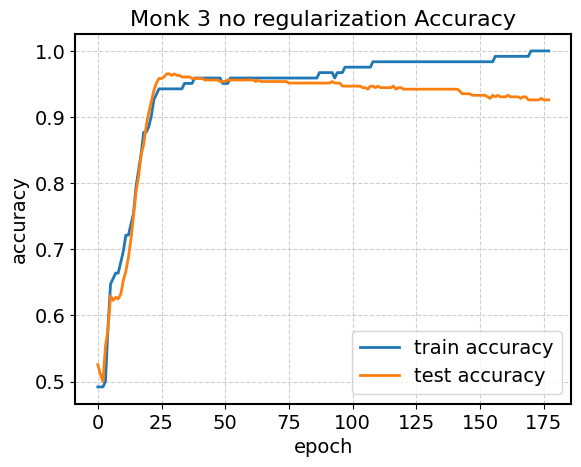

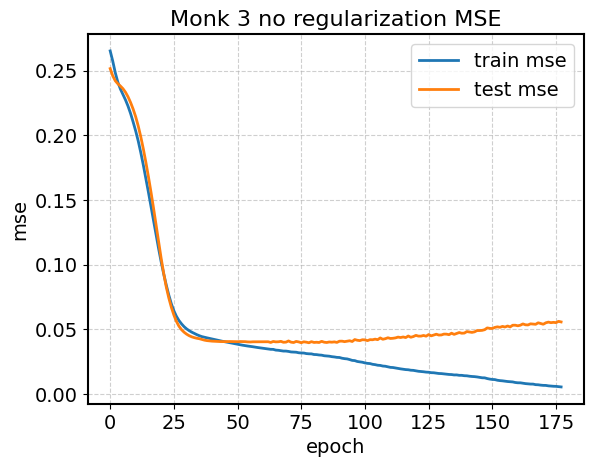

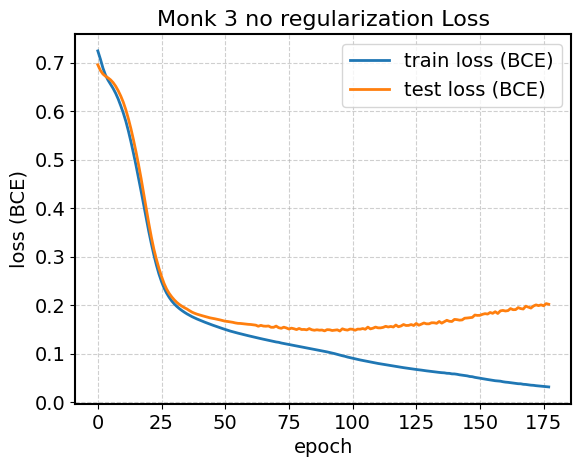

Train Accuracy: 100.0%
Test Accuracy: 92.5925925925926%


In [6]:
### chosen overfitting configuration
'''Config index: ([17, 8, 8, 1], ['relu', 'relu', 'identity'], 'binary cross entropy sigmoid', 0.25, 0, 0.5, -1), Mean Accuracy: 94.3%,
        training instability coeff validation: 0.5101067216534323, 
        training instability coeff train: 0.0035634011571540245, 
        training loss-val loss diff: 14.215801300638915, 
        Mean Epochs: 178
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set, we further increase the architecture complexity to force overfitting
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 8, 8, 1], ['relu', 'relu', 'identity'], 'binary cross entropy sigmoid', 0.25, 0, 0.5, -1
EPOCHS = 178
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_monk=True, plot_title='Monk 3 no regularization')

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 3 no regularization Loss', save_plots=True)

# train accuracy
out = nn.forward(X_train_full)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Train Accuracy: {np.mean(predictions == y_train_full) * 100}%")

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Test Accuracy: {np.mean(predictions == y_test) * 100}%")